In [2]:
import sys 
#sys.path.append('/home/jmeyer/git/jan_meyer_esn')
sys.path.insert(0,'..')

import glob
import datetime

import os

#import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import pandas as pd

from scipy.optimize import curve_fit

from src.get_data import get_data
from src.utils import *
from src.model import *
from src.train_ESN_callback import train_ESN_callback
from src.reset_states_callback import reset_states_callback

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,7)
plt.rcParams.update({'savefig.dpi': 500})
plt.rcParams.update({'font.size': 14})

import seaborn as sns

In [3]:
simple = not True

In [4]:
if simple == True:
    esn_hyperparameter = { "nodes": 300, "leaky": 1.0 - 1.0e-10, "kappa": 20, 
                        "spectral_radius": 5.0, "sigma": 0.34, "bs":1, 
                        "n_esn": 1, "overlay_ratio": 0.025, "stateful": True }
    train_params = { "epochs": 1,
                  "train_length": int( 10e3 ), "validation_length": int( 5e3 ),
                  "loss_function": 'mse', "sparse": True,
                  "optimizer": tf.keras.optimizers.Adam( 1e-6 ), "lr_decay": 5e-2, "output_by_gradient": True } 
else:
    esn_hyperparameter = { "nodes": 5000, "leaky": 1.0, "kappa": 3, 
                    "spectral_radius": 0.6, "sigma": 0.2, "bs":1, 
                    "n_esn": 1, "overlay_ratio": 0.025, "stateful": True } #n_esn must be true denominator of system_params["N"]
    train_params = { "epochs": 1, #overlay=0.025 -> l = 6
                  "train_length": int( 50e3 ), "validation_length": int( 5e3 ),
                  "loss_function": 'mse', "sparse": True,
                  "optimizer": tf.keras.optimizers.Adam( 1e-6 ), "lr_decay": 5e-2, "output_by_gradient": True } 

system_params = { "N": 64, "L": 22, 
                  "F": 8, 
                  "dt": 0.25, "tmax": int( 1e5 ),
                  "time_length": train_params["train_length"] } 

n_samples = train_params["train_length"] + train_params["validation_length"]
validation_split = train_params["validation_length"] / n_samples
batch_size = int( system_params["time_length"] / 20 ) 

warmup_steps = 100

how_much = min( int ( 100 / system_params["dt"] ), train_params["validation_length"] ) #approx 4 lyapunovtimes

#train_params["validation_length"] = how_much 

prediction_steps = how_much

lambda_max = 0.09
print( how_much * system_params["dt"] * lambda_max )
n_lyap = int( how_much * system_params["dt"] * lambda_max)
print( n_lyap )

9.0
9


In [5]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="2" 
if train_params["output_by_gradient"]==False:
    os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

In [6]:
f = os.getenv( "HOME" ) + "/ownCloud/Master_Arbeit/Mine/genKSE_simple/*" #"/ownCloud/Master_Arbeit/Mine/genKSE/KuramotoSivashinsky_L_200_Q_512_Nt_*_dt_{}".format( system_params["dt"] ) 

timelines = glob.glob( f + "_l2*c_00001.npy" )

print( f, "\n" )
print( len(timelines ) )
print( timelines )

/home/jan_meyer/ownCloud/Master_Arbeit/Mine/genKSE_simple/* 

4
['/home/jan_meyer/ownCloud/Master_Arbeit/Mine/genKSE_simple/KuramotoSivashinsky_L_22_Q_64_Nt_5000000_dt_0.25_l2_0.06011_c_00001.npy', '/home/jan_meyer/ownCloud/Master_Arbeit/Mine/genKSE_simple/KuramotoSivashinsky_L_22_Q_64_Nt_1000000_dt_0.25_l2_0.05373_c_00001.npy', '/home/jan_meyer/ownCloud/Master_Arbeit/Mine/genKSE_simple/KuramotoSivashinsky_L_22_Q_64_Nt_1000000_dt_0.25_l2_0.061_c_00001.npy', '/home/jan_meyer/ownCloud/Master_Arbeit/Mine/genKSE_simple/KuramotoSivashinsky_L_22_Q_64_Nt_5000000_dt_0.25_l2_0.0572_c_00001.npy']


In [7]:
noise = []
for i in range( len( timelines ) ):
    noise.append( float( timelines[ i ].split( "l2_" )[ 1 ].split( "_c_" )[ 0 ] ) )
noise = np.array( noise )
print( len(noise) )

4


In [8]:
p = ( noise / np.amax( 100. * noise ) ).argsort()

In [9]:
timelines = np.array( timelines )
timelines = timelines[ p ]
noise = noise[ p ]

len( timelines )

#noise

4

In [10]:
#for i in range( len(timelines) ):
#   print( timelines[i] )
print( timelines[ 0 ], timelines[ 1 ])

/home/jan_meyer/ownCloud/Master_Arbeit/Mine/genKSE_simple/KuramotoSivashinsky_L_22_Q_64_Nt_1000000_dt_0.25_l2_0.05373_c_00001.npy /home/jan_meyer/ownCloud/Master_Arbeit/Mine/genKSE_simple/KuramotoSivashinsky_L_22_Q_64_Nt_5000000_dt_0.25_l2_0.0572_c_00001.npy


In [11]:
#inputs = get_data( system_params, train_params, 3 ) #1
n_samples = train_params["train_length"] + train_params["validation_length"]

inputs = np.load( timelines[ 0 ] )[ :, : n_samples ]
inputs.shape

(64, 55000)

In [12]:
#inputs_2 = np.load( timelines[ 3 ] )[ :, : n_samples ]
inputs_2 = np.load( 
    timelines[ -1 ]
    #[ 2 ] 
    )[ :, : train_params["train_length"] + how_much ]

inputs_2.shape

(64, 50400)

In [13]:
inputs = transform( normalize( inputs ) )
inputs.shape

(55000, 1, 64)

In [14]:
inputs_2 = transform( normalize( inputs_2 ) )
inputs_2.shape

(50400, 1, 64)

In [15]:
def scheduler( epoch, lr ):
    return  lr * tf.math.exp( -1* train_params["lr_decay"] ) 
learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler( scheduler, verbose=0 ) 

In [16]:
model = esn_model( esn_hyperparameter, train_params, system_params )
#tf.keras.utils.plot_model( model, show_shapes = True )

In [17]:
#for layer in model.layers: 
#    print( layer.name )

In [18]:
log_dir = os.getenv( "HOME" ) + "/git/jan_meyer_esn/tensorboard_logs/fit/" + datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S") + "_nESN_{}_nodes_{}_r_{}_leaky_{}".format( esn_hyperparameter["n_esn"], esn_hyperparameter["nodes"], esn_hyperparameter["spectral_radius"], esn_hyperparameter["leaky"] )
tensorboard_callback = tf.keras.callbacks.TensorBoard( log_dir=log_dir, histogram_freq=1 )
log_dir

'/home/jan_meyer/git/jan_meyer_esn/tensorboard_logs/fit/2021_10_01-19_25_11_nESN_1_nodes_5000_r_0.6_leaky_1.0'

In [19]:
history = model.fit( inputs[ : -1 ], inputs[ 1 : ], # watch_dim
                    batch_size = batch_size, epochs = train_params["epochs"], 
                    shuffle = False, validation_split = validation_split, verbose = 1,
                    callbacks = [ #reset_states_callback(),
                                  train_ESN_callback( inputs[ : train_params["train_length"] ], esn_hyperparameter, train_params["sparse"], system_params["time_length"]
                                  ,epochs = [ int( train_params["epochs"] ) - 1 ] 
                                  ), 
                                  #learning_rate_scheduler,
                                  #tensorboard_callback 
                                  ] 
                    )

esn: input_1 -> dense


Regression in 64 Dimensions : 100%|██████████| 49999/49999 [00:36<00:00, 1361.77it/s]


20/20 [==============================] - 8s 377ms/step - loss: 2.7455e-09 - mae: 3.5109e-05 - val_loss: 1.1401e-08 - val_mae: 6.0383e-05


In [20]:
for l in model.layers:
    print(l.name, l.trainable)

input_1 False
esn False
transformer False
dense False


In [21]:
#
# plot_loss( history )

In [22]:
train_data = inverse_transform( inputs[ : train_params["train_length"] ] )
val_data = inverse_transform( inputs[ train_params["train_length"] : ] )
val_data.shape

(64, 5000)

In [23]:
train_data_2 = inverse_transform( inputs_2[ : train_params["train_length"] ] )
val_data_2 = inverse_transform( inputs_2[ train_params["train_length"] : ] )
val_data_2.shape

(64, 400)

In [24]:
reset_states( model )
train_pred = model.predict( inputs[ : train_params["train_length"] ], batch_size = batch_size, callbacks = [ reset_states_callback() ] ) #Callback NOT called!
train_prediction = inverse_transform( train_pred )#, esn_hyperparameter["bs"] )

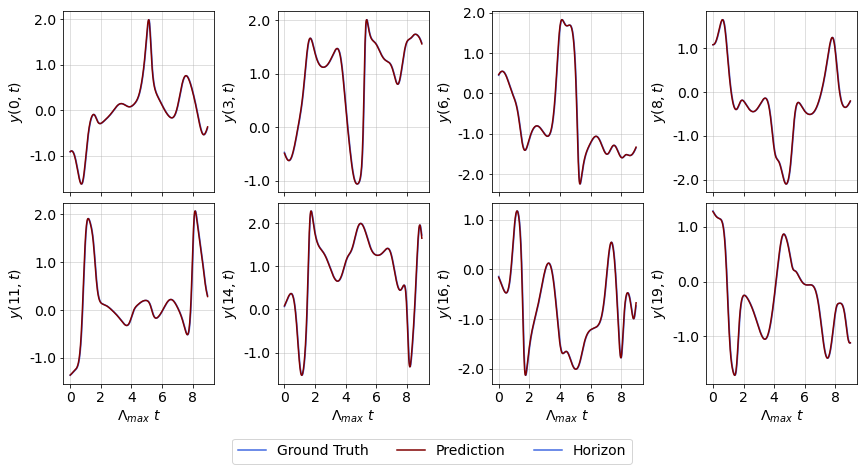

-1
-0.0225


In [25]:
plot( train_data, train_prediction, train_params["train_length"] - how_much, how_much, n_lyap, 8, system_params["L"], system_params["N"] ) 

In [26]:
freq = max( 1, how_much // 1000 )
freq

1

In [27]:
cmap = "viridis" #"RdGy" #"cividis"

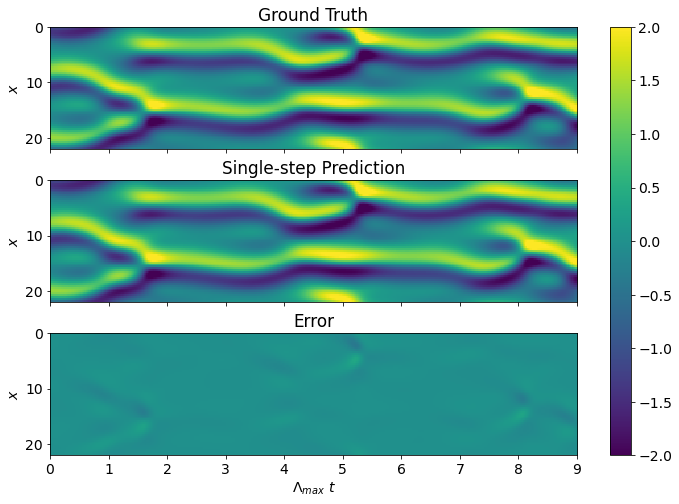

In [28]:
vmin = -2
vmax = 2
fig, axs = plt.subplots( 3, sharex=True, sharey=True )
im = axs[0].imshow( train_data[ :, -1* how_much : : freq  ], interpolation='nearest', extent=[0,n_lyap,system_params["L"],0], aspect="auto", vmin=vmin, vmax=vmax, cmap = cmap )

axs[0].set_title( "Ground Truth" )

axs[1].imshow( train_prediction[ :, -1* how_much : : freq  ], interpolation='nearest', extent=[0,n_lyap,system_params["L"],0], aspect="auto", vmin=vmin, vmax=vmax, cmap = cmap )
axs[1].set_title( "Single-step Prediction" )

axs[2].imshow( ( train_data - train_prediction )[ :, -1* how_much : : freq  ], interpolation='nearest', extent=[0,n_lyap,system_params["L"],0], aspect="auto", vmin=vmin, vmax=vmax, cmap = cmap )
axs[2].set_title( "Error" )

for i in range( 3 ):
    axs[i].set_ylabel( r"$x$" )
    
plt.xlabel(r"$\Lambda_{max}~ t$")
plt.tight_layout( pad=0.5 )

fig.colorbar(im, ax=axs.ravel().tolist())
fig.savefig('./../Results/Warmup.png')
fig.savefig('./../Results/Warmup.svg')
#tikzplotlib.save('./../Results/Warmup.tex')

In [29]:
prediction = future_loop( model, how_much, esn_hyperparameter, system_params, train_pred[ -1 ] )
pred = inverse_transform( prediction )#, esn_hyperparameter["bs"] )
val_data = val_data[ :, : how_much ]

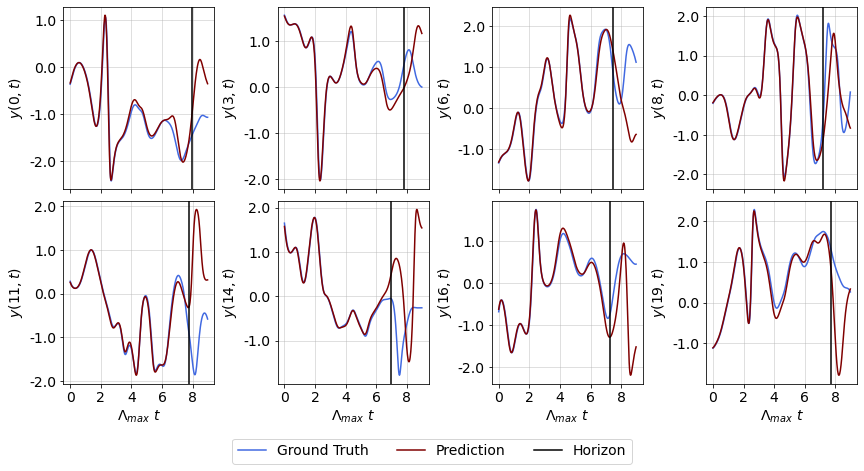

344
7.74


In [30]:
plot( val_data, pred, 0, how_much, n_lyap, 8, system_params["L"], system_params["N"], "loop1" ) 

In [31]:
val_data.shape

(64, 400)

(400,)
320
323
7.2675


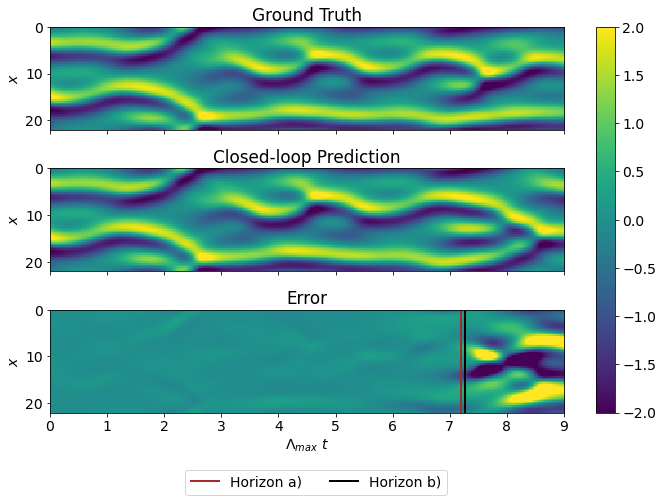

In [32]:
fig, axs = plt.subplots( 3, sharex=True, sharey=True )
im = axs[0].imshow( val_data[ :, : how_much : freq  ], interpolation='nearest', extent=[0,n_lyap,system_params["L"],0], aspect="auto", vmin=vmin, vmax=vmax, cmap = cmap )
axs[0].set_title( "Ground Truth" )

axs[1].imshow( pred[ :, : how_much : freq  ], interpolation='nearest', extent=[0,n_lyap,system_params["L"],0], aspect="auto", vmin=vmin, vmax=vmax, cmap = cmap )
axs[1].set_title( "Closed-loop Prediction" )

axs[2].imshow( ( val_data - pred )[ :, : how_much : freq  ], interpolation='nearest', extent=[0,n_lyap,system_params["L"],0], aspect="auto", vmin=vmin, vmax=vmax, cmap = cmap )
axs[2].set_title( "Error" )

print( np.amax( val_data-pred, axis=0).shape )

c = 0
d = 0
for i in np.abs( np.amax( val_data-pred, axis=0) ) > 0.5:
    if i == True:
        break
    c += 1
print( c )

d = horizon( val_data - pred, 0.5 )
print( d )
print( d * system_params["dt"] * lambda_max )

axs[2].axvline( x = c * system_params["dt"] * lambda_max, c="brown", label = 'Horizon a)', linewidth=2 )
axs[2].axvline( x = d * system_params["dt"] * lambda_max, c="black", label = 'Horizon b)', linewidth=2 )
plt.legend( ncol=2, loc = 'lower center', bbox_to_anchor=[0.45, -0.012], bbox_transform=fig.transFigure )

for i in range( 3 ):
    axs[i].set_ylabel( r"$x$" )

plt.xlabel(r"$\Lambda_{max}~ t$")
plt.tight_layout( pad=0.5 )

plt.tight_layout()
fig.colorbar(im, ax=axs.ravel().tolist())
#fig.suptitle('Validation data', x = 0.44, fontsize = 15 )
#tikzplotlib.save('./../Results/Prediction.tex')
fig.savefig('./../Results/Prediction.png')
fig.savefig('./../Results/Prediction.svg')

In [33]:
#Different starting conditions:
reset_states( model )
train_pred_2 = model.predict( inputs_2[ : train_params["train_length"] ], batch_size = batch_size, callbacks = [ reset_states_callback() ] ) #Callback NOT called!
train_prediction_2 = inverse_transform( train_pred_2 )#, esn_hyperparameter["bs"] )

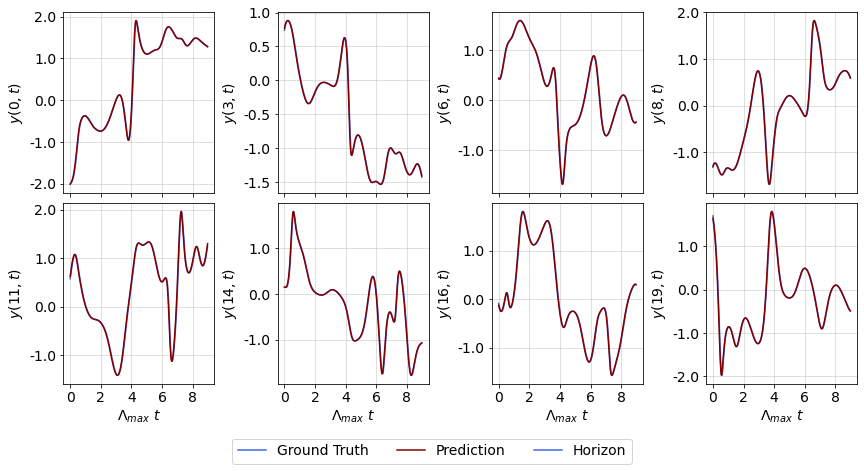

-1
-0.0225


In [34]:
#plot( train_data_2, train_prediction_2, train_params["train_length"] - how_much, how_much, n_lyap, 8 ) 
plot( train_data_2, train_prediction_2, train_params["train_length"] - how_much, how_much, n_lyap, 8, system_params["L"], system_params["N"] ) 

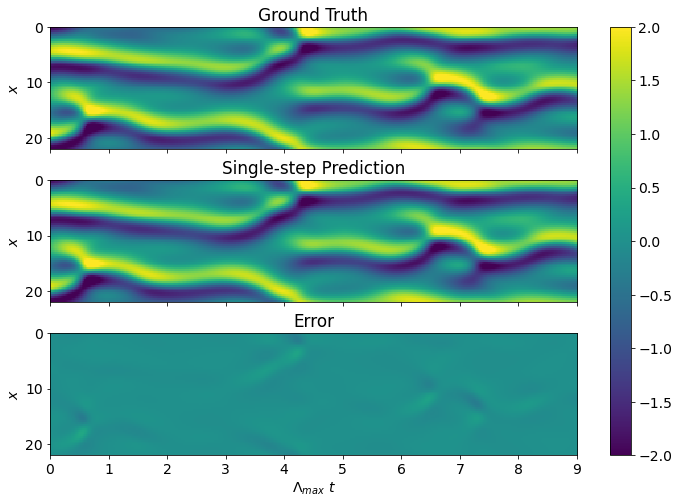

In [35]:
vmin = -2
vmax = 2
fig, axs = plt.subplots( 3, sharex=True, sharey=True )
im = axs[0].imshow( train_data_2[ :, -1* how_much : : freq  ], interpolation='nearest', extent=[0,n_lyap,system_params["L"],0], aspect="auto", vmin=vmin, vmax=vmax, cmap = cmap )
axs[0].set_title( "Ground Truth" )
axs[1].imshow( train_prediction_2[ :, -1* how_much : : freq  ], interpolation='nearest', extent=[0,n_lyap,system_params["L"],0], aspect="auto", vmin=vmin, vmax=vmax, cmap = cmap )
axs[1].set_title( "Single-step Prediction" )
axs[2].imshow( ( train_data_2 - train_prediction_2 )[ :, -1* how_much : : freq  ], interpolation='nearest', extent=[0,n_lyap,system_params["L"],0], aspect="auto", vmin=vmin, vmax=vmax, cmap = cmap )
axs[2].set_title( "Error" )

for i in range( 3 ):
    axs[i].set_ylabel( r"$x$" )

plt.xlabel(r"$\Lambda_{max}~ t$")
plt.tight_layout( pad=0.5 )

fig.colorbar(im, ax=axs.ravel().tolist())
fig.savefig('./../Results/Warmup_2.png')
fig.savefig('./../Results/Warmup_2.svg')
#tikzplotlib.save('./../Results/Warmup_2.tex')

In [36]:
prediction_2 = future_loop( model, how_much, esn_hyperparameter, system_params, train_pred_2[ -1 ] )
pred_2 = inverse_transform( prediction_2 )#, esn_hyperparameter["bs"] )
val_data_2 = val_data_2[ :, : how_much ]

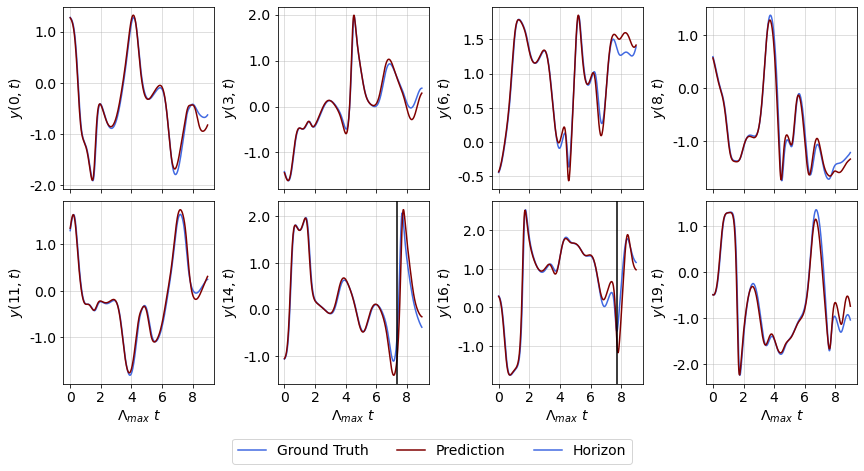

-1
-0.0225


In [37]:
plot( val_data_2, pred_2, 0, how_much, n_lyap, 8, system_params["L"], system_params["N"], "loop2" )

321
-1
-0.0225


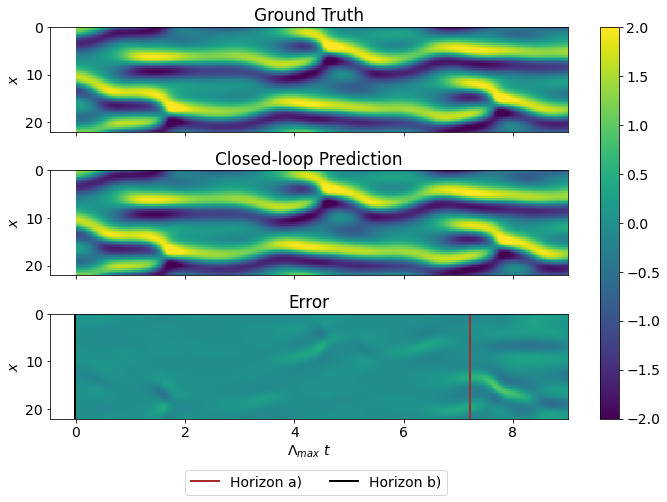

In [38]:
fig, axs = plt.subplots( 3, sharex=True, sharey=True )
im = axs[0].imshow( val_data_2[ :, : how_much : freq  ], interpolation='nearest', extent=[0,n_lyap,system_params["L"],0], aspect="auto", vmin=vmin, vmax=vmax, cmap = cmap )
axs[0].set_title( "Ground Truth" )
axs[1].imshow( pred_2[ :, : how_much : freq  ], interpolation='nearest', extent=[0,n_lyap,system_params["L"],0], aspect="auto", vmin=vmin, vmax=vmax, cmap = cmap )
axs[1].set_title( "Closed-loop Prediction" )
axs[2].imshow( ( val_data_2 - pred_2 )[ :, : how_much : freq  ], interpolation='nearest', extent=[0,n_lyap,system_params["L"],0], aspect="auto", vmin=vmin, vmax=vmax, cmap = cmap )
axs[2].set_title( "Error" )

c = 0
d = 0
for i in np.abs( np.amax( val_data_2-pred_2, axis=0) ) > 0.5:
    if i == True:
        break
    c += 1
print( c )

d = horizon( val_data_2 - pred_2, 0.5 )
print( d )
print( d * system_params["dt"] * lambda_max )

axs[2].axvline( x = c * system_params["dt"] * lambda_max, c="brown", label = 'Horizon a)', linewidth=2 )
axs[2].axvline( x = d * system_params["dt"] * lambda_max, c="black", label = 'Horizon b)', linewidth=2 )
plt.legend( ncol=2, loc = 'lower center', bbox_to_anchor=[0.45, -0.012], bbox_transform=fig.transFigure )

for i in range( 3 ):
    axs[i].set_ylabel( r"$x$" )

plt.xlabel(r"$\Lambda_{max}~ t$")

plt.tight_layout()
fig.colorbar(im, ax=axs.ravel().tolist())

#fig.suptitle('Prediction in Loop 2')
fig.savefig('./../Results/Prediction_2.png')
fig.savefig('./../Results/Prediction_2.svg')
#tikzplotlib.save('./../Results/Prediction_2.tex')

In [39]:
#save_weights( model, train_params["sparse"], os.getenv("HOME") + '/ownCloud/Master_Arbeit/Mine/model/nESN_{}_units_{}_trainlength_{}'.format(
#    esn_hyperparameter["n_esn"], esn_hyperparameter["nodes"], train_params["train_length"] ) )

In [40]:
#load_weights( model, train_params["sparse"], os.getenv("HOME") + '/ownCloud/Master_Arbeit/Mine/model/nESN_{}_units_{}_trainlength_{}'.format(
#    esn_hyperparameter["n_esn"], esn_hyperparameter["nodes"], train_params["train_length"] ) )
#model.weights

In [41]:
warmup_steps = [ 100, 17, 10, 7, 5 ][ : : -1 ] 
max_warmup = max( warmup_steps )

In [42]:
shift = max_warmup + prediction_steps
N_sec = int( train_params["validation_length"] / shift )

if simple:
    N_sec = 3
N_sec

10

In [43]:
reset_states( model )
trans_horizons = []
for transf in [ 'Identity', 'Pathak' ]:
    horizons = np.zeros( N_sec )
    if transf == 'Identity':
        print( 'Identity' )
        alter_transformer( model, np.ones( esn_hyperparameter["nodes"] ), np.ones( esn_hyperparameter["nodes"] ) )
    else:
        print( 'Pathak' )
        alter_transformer( model, ( np.arange( esn_hyperparameter["nodes"] ) + 1 ) % 2 + 1, np.ones( esn_hyperparameter["nodes"] ) )

    for i in tqdm( range( N_sec ), desc = "Transformer = {}".format( transf ) ):
        sector = transform( normalize( np.load( timelines[0] )[ :, train_params["train_length"] + shift * i : train_params["train_length"] + shift * ( i + 1 ) ] ) )
        reset_states( model )
        warmup_pred = model.predict( sector[ : max_warmup ], batch_size = 10 )
        prediction = future_loop( model, prediction_steps, esn_hyperparameter, system_params, warmup_pred[ -1 ] )
        diff = inverse_transform( np.abs( prediction - sector[ max_warmup :  ] ) )
        h = horizon( diff, 0.5 ) * system_params["dt"] * lambda_max
        horizons[ i ] = h
    trans_horizons.append( horizons )
trans_horizons = np.array( trans_horizons )

Transformer = Identity:   0%|          | 0/10 [00:00<?, ?it/s]

Identity
altered  transformer
altered  esn


Transformer = Pathak:   0%|          | 0/10 [00:00<?, ?it/s]

Pathak
altered  transformer
altered  esn


Transformer = Pathak: 100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


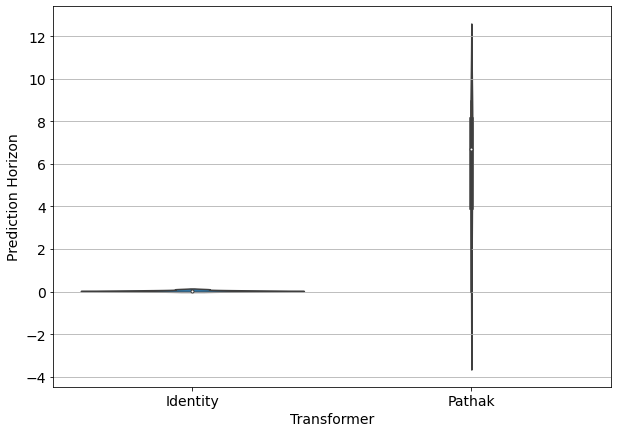

In [44]:
v_data = pd.DataFrame( trans_horizons.transpose(), columns = [ 'Identity', 'Pathak' ] )
sns.violinplot( data = v_data )
plt.ylabel( 'Prediction Horizon')
plt.xlabel( 'Transformer' )
plt.grid( axis = 'y')
#plt.tight_layout()
plt.savefig('./../Results/trans_violin.png')
plt.savefig('./../Results/trans_violin.svg') 

In [45]:
reset_states( model )

all_horizons = []

for w_step in warmup_steps:
    horizons = np.zeros( N_sec )

    for i in tqdm( range( N_sec ), desc = "warmupsteps = {}".format( w_step ) ):
    
        sector = transform( normalize( np.load( timelines[0] )[ :, train_params["train_length"] + shift * i : train_params["train_length"] + shift * ( i + 1 ) ] ) )
        reset_states( model )
        warmup_pred = model.predict( sector[ max_warmup - w_step : max_warmup ], batch_size = 10 )
        prediction = future_loop( model, prediction_steps, esn_hyperparameter, system_params, warmup_pred[ -1 ] )
        diff = inverse_transform( np.abs( prediction - sector[ max_warmup :  ] ) )
        h = horizon( diff, 0.5 ) * system_params["dt"] * lambda_max
        horizons[ i ] = h

    #print( horizons )
    all_horizons.append( horizons )
np.save( "./../Results/violin_horizons", all_horizons )
np.array( all_horizons ).shape

warmupsteps = 100: 100%|██████████| 10/10 [00:18<00:00,  1.89s/it]


(5, 10)

In [46]:
all_horizons = np.load( "./../Results/violin_horizons.npy" )
all_horizons

array([[ 8.2125,  3.51  ,  5.085 ,  7.425 ,  8.0775,  7.9425, -0.0225,
         7.9425,  1.845 ,  3.06  ],
       [ 8.19  ,  3.8025,  5.22  ,  7.3125,  8.46  ,  7.7175,  7.515 ,
        -0.0225,  5.76  ,  3.285 ],
       [ 8.1675,  3.555 ,  5.2875,  8.055 ,  8.6625,  7.7625,  8.82  ,
         5.985 ,  2.115 ,  3.4875],
       [ 8.2125,  3.5775,  5.265 , -0.0225,  8.55  ,  7.74  , -0.0225,
        -0.0225,  5.76  ,  3.465 ],
       [ 8.235 ,  3.5775,  5.2425, -0.0225,  8.5275,  7.7175,  7.605 ,
         8.955 ,  5.76  ,  3.4875]])

In [47]:
titles = list( map( str, warmup_steps ) )
violin_data = pd.DataFrame( all_horizons.transpose(), columns = titles )
#violin_data

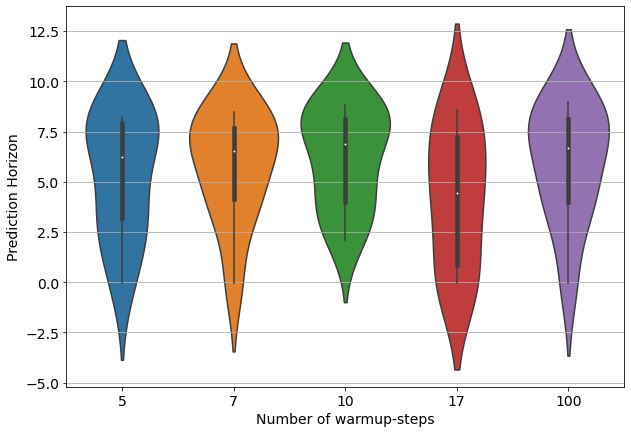

In [48]:
sns.violinplot( data = violin_data )
plt.ylabel( "Prediction Horizon")
plt.xlabel( r"Number of warmup-steps")
plt.grid( axis = 'y')
#plt.tight_layout()
plt.savefig('./../Results/horizons_violin.png')
plt.savefig('./../Results/horizons_violin.svg') 
#https://seaborn.pydata.org/_images/seaborn-violinplot-4.png

In [49]:
'''warmup_steps = 100
prediction_steps = how_much'''

N_h = len( timelines )
if simple == True:
    N_h = 20
horizons = []
for i in tqdm( range( N_h ), desc = "timelines" ):
    #print( i, timelines[ i ] )
    timeline = transform( normalize( np.load( timelines[i] )[ :, : max_warmup + prediction_steps ] ) )
    warmup_pred = model.predict( timeline[ : max_warmup ], batch_size = max_warmup )
    prediction = future_loop( model, prediction_steps, esn_hyperparameter, system_params, warmup_pred[ -1 ] )
    diff = inverse_transform( np.abs( prediction - timeline[ max_warmup: max_warmup + prediction_steps ] ) )
    h = horizon( diff, 0.5 ) * system_params["dt"] * lambda_max
    #print( i, noise[ i ], h )
    horizons.append( h )
#horizons

timelines: 100%|██████████| 4/4 [00:39<00:00,  9.85s/it]


In [50]:
diff.shape

(64, 400)

In [51]:
noise.shape

(4,)

In [52]:
print( len( horizons ) )
noise_horizons = np.stack( [ noise[ : N_h ], horizons[ : N_h ] ] )
print( noise_horizons.shape )
np.save( './../Results/noise_horizons', noise_horizons )

4
(2, 4)


In [53]:
noise, horizons = np.load( './../Results/noise_horizons.npy' )

In [54]:
def func( x, a, b, c ):
    return a * np.log( x + b ) + c

#def func_1( x, a, b, c ):
#    return a / ( x + b ) + c

In [55]:
popt, pcov = curve_fit( func, noise, horizons )
print( popt, pcov )

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [56]:
y_fitted = func( noise, popt[ 0 ], popt[ 1 ], popt[ 2 ] )
y_fitted.shape

NameError: name 'popt' is not defined

In [57]:
#popt_1, pcov_1 = curve_fit( func_1, noise, horizons )
#print( popt_1, pcov_1 )

In [58]:
#Verteilung des Erwartungshorizonts für unterschiedliche Startbedingen als boxplot oder violinplot
#Anderer Zeitausschnitt Info speichern wie weit entfernt vom Trainingsende
#Lorenz63 Takens theorem benutzen: nur eine Dimension beobachten: x, x-tau, x-2tau -> Ähnlichkeit zu original immer drei Dimensional Schmetterling, tau zb. 10 oder 20

In [59]:
delta = y_fitted - horizons
d_ = delta.std( ddof = 1 )

NameError: name 'y_fitted' is not defined

In [ ]:
#https://stackoverflow.com/questions/6963035/pyplot-axes-labels-for-subplots/36542971#36542971

In [60]:
r_std = []
window_len = 100
for i in range( len( delta ) ):
    s_ = int( max( 0, i - window_len / 2 ) )
    e_ = int( min( len( delta ), i + window_len / 2 ) )
    #print( s_, e_ )
    window = delta[ s_ : e_ ]
    r_std.append( np.std( window ) )

NameError: name 'delta' is not defined

In [61]:
start = np.amin( noise ) 
stop = np.amax( noise ) + 0.01
N = len( timelines )
stop

0.071

In [62]:
coarse_grain = 40
bins = np.linspace( start, stop, int( N / coarse_grain ) )
bins

array([], dtype=float64)

In [63]:
centers = (bins[1:]+bins[:-1])/2
noise_grained = centers[ np.digitize( noise, bins ) -1 ]

IndexError: index -1 is out of bounds for axis 0 with size 0

In [ ]:
#noise_grained

In [64]:
plt.plot( noise_grained, horizons, 'o' )

NameError: name 'noise_grained' is not defined

In [65]:
med = []
for i in range( bins.shape[0] - 1 ):
    #hor_section = horizons[ np.where( ( bins[ i ] < noise ) and ( noise < bins[ i + 1 ] ), True, False ) ]
    
    noise_section = np.ma.masked_inside( noise, bins[ i ], bins[ i + 1 ] ).mask
    hor_section = horizons[ noise_section ]
    med.append( np.median( hor_section ) )
med

[]

In [66]:
centers

array([], dtype=float64)

In [67]:
noise_horizons_grained = pd.DataFrame( { 'noise': list( noise_grained ), 'horizons': list( horizons ) } )
#noise_horizons_grained

NameError: name 'noise_grained' is not defined

NameError: name 'y_fitted' is not defined

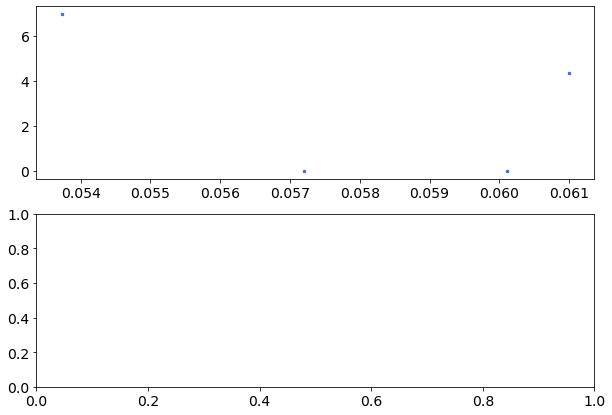

In [68]:
fig, axs = plt.subplots( nrows = 2 ) #, sharex = True

axs[0].plot( noise, horizons, 'royalblue', linestyle = 'None', marker = ".", 
             markersize = 5, label = "Horizons( l2 )" )
axs[0].plot( noise, y_fitted, 'cornflowerblue', label = r"{} {}$\cdot \ln( $ l2 $ + {} )$".format( round( popt[ 2 ], 2 ), round( popt[ 0 ], 2 ), round( popt[ 1 ], 2 ) ) )
#axs[0].plot( noise, func_1( noise, popt_1[ 0 ], popt_1[ 1 ], popt_1[2] ), 'slategray', label = r"{} / ( {} + l2 ) + {}".format( round( popt_1[ 0 ], 3 ), round( popt_1[ 1 ], 3 ), round( popt_1[ 2 ], 3 ) ) )

axs[0].grid( True )

axs[0].legend( loc = 'upper right' )
plt.grid( True )

#sns.set_style("whitegrid")

#axs[1].set_xticks( centers )

axs[1] = sns.violinplot( noise_grained, horizons ) #, ax = axs[0]
#axs[1].plot( centers, med, label = 'median' )

axs[ 1 ].plot( med, label = 'Median' )
axs[1].legend( loc = 'upper right' )

axs[1].set_xticklabels( np.round( centers, 1 ) )
fig.text(0.5, 0.04, 'Perturbation (l2-norm)', va='center', ha='center', fontsize=plt.rcParams['axes.labelsize'])
fig.text(0.04, 0.5, r'Prediction Horizon', va='center', ha='center', rotation='vertical', fontsize=plt.rcParams['axes.labelsize'])

#tikzplotlib.save('./../Results/Noise_Robustness.tex')
plt.savefig('./../Results/Noise_Robustness.png' )
plt.savefig('./../Results/Noise_Robustness.svg' )